In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-06-07 
Git hash: 5d75a010c3a45348c61a4d9d358243b80eba07e5


In [2]:
# Imports and settings
from ncbi_remap.parser import parse_picardCollect_hist, parse_featureCounts_jcounts, parse_featureCounts_counts
from sklearn import preprocessing, svm

pd.options.display.max_columns = 999

In [3]:
# Connect to database
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra']
remap = db['remap']
biometa = db['biometa']
ncbi = db['ncbi']

In [4]:
# Import counts
with open('../../data/1508_s2_cell_brian_annot.txt', 'r') as fh:
    s2 = [x.strip() for x in fh]

# S2 Cell Summary

This document explores putative S2 cell data. I quired all attribute fields of the [biometa database](https://github.com/jfear/ncbi_biometa) with the case insensitive regular expression `'^(\s*|.*\s)(s2|Schneider)(R\+\s|,\s|\s|\s*).*$'`. This resulted in 1,243 BioSamples that appear to be related to S2 cells. From this list of BioSamples I extracted {{ '{:,}'.format(len(s2)) }} SRRs. 

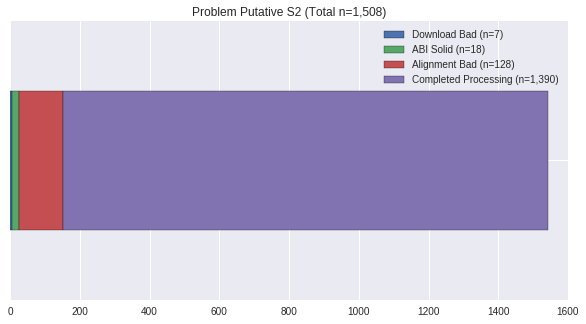

In [5]:
# Plot various flags from pre-alngnment pipeline
s2Flags = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': s2}, 
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr',
            'flag_download_bad': {
                '$cond': {
                    'if': {'$in': ['download_bad', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
            'flag_abi_solid': {
                '$cond': {
                    'if': {'$in': ['abi_solid', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
            'flag_alignment_bad': {
                '$cond': {
                    'if': {'$in': ['alignment_bad', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
            'flag_complete': {
                '$cond': {
                    'if': {'$in': ['complete', '$runs.pre_aln_flags']}, 
                    'then': 1, 
                    'else': 0
                },
            },
        }
    },
])))

s2Flags.set_index('srr', inplace=True)

_df = s2Flags.sum().sort_values().to_frame().T
fig, ax = plt.subplots(1,1, figsize=(10,5))
_df.plot.barh(stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
newLabels = []

mapper = {
    'flag_download_bad': 'Download Bad',
    'flag_abi_solid': 'ABI Solid',
    'flag_alignment_bad': 'Alignment Bad',
    'flag_complete': 'Completed Processing'
}

for l in labels:
    newLabels.append(mapper[l] + ' (n={:,})'.format(_df.ix[0, l]))
plt.legend(handles, newLabels)
ax.set_yticklabels([])
ax.set_title('Problem Putative S2 (Total n={:,})'.format(s2Flags.shape[0]));

In [6]:
# How many of the s2 samples are Brian's?
oliverAuthor = []
for srx in list(remap.find({
    'papers.authors.first_name': 'Brian',
    'papers.authors.last_name': 'Oliver'
}, {'_id': 0})):
    for run in srx['runs']:
        oliverAuthor.append(run['srr'])
        
for srx in list(remap.find({
    'contacts.first_name': 'Brian',
    'contacts.last_name': 'Oliver'
}, {'_id': 0})):
    for run in srx['runs']:
        oliverAuthor.append(run['srr'])
        
oliver = list(set(oliverAuthor))

s2Oliver = pd.DataFrame(index=s2Flags.index, columns=['flag_oliver']).fillna(0)
s2Oliver[s2Oliver.index.isin(oliver)] = 1

print('Of the {:,} putative S2 samples, {:,} are from Brian\'s lab.'.format(s2Oliver.shape[0], s2Oliver.sum().values[0]))

# Get list of paper titles
s2OliverIndex = s2Oliver.index[s2Oliver.flag_oliver == 1].tolist()
oliverTitles = list(set([x['papers'][0]['title'] for x in remap.find({
    'runs.srr': {'$in': s2OliverIndex},
    'papers.title': {'$exists': 1}
},
{
    '_id': 0,
    'papers.title': 1
})]))

print('\nThese projects had papers with the following titles:\n\n* {}'.format('\n* '.join(oliverTitles)))


Of the 1,508 putative S2 samples, 31 are from Brian's lab.

These projects had papers with the following titles:

* Synthetic spike-in standards for RNA-seq experiments.
* Expression in aneuploid Drosophila S2 cells.
* Sex- and tissue-specific functions of Drosophila doublesex transcription factor target genes.


## Technical Quality Control

### Strandedness

Strandedness was determined by looking at the number of reads aligning to a specific strand. Read relationship with the genome model was used to determine if the majority of reads are on the **same strand** as the gene model, the **opposite strand** as the gene model, or equally on either strand. 

**Threshold Criteria:** 75% of reads went to one strand

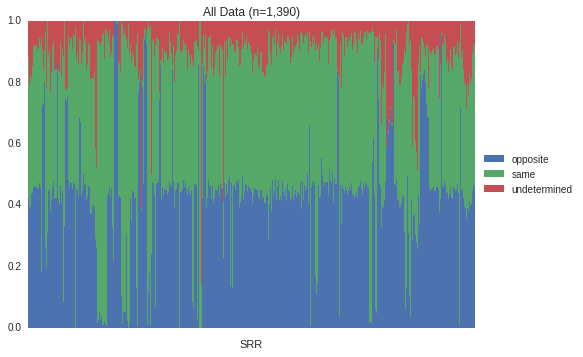

In [7]:
# Plot Strandedness all samples
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
            '$match': {
                '$and': [
                    {'runs.srr': {'$in': s2}},
                    {'runs.pre_aln_flags': 'complete'}
                ]
        },
    },
    {
        '$project': {
            'srx': '$srx',
            'srr': '$runs.srr',
            'same': '$runs.pre_aln_workflow.infer_expeirment.same_strand',
            'opposite': '$runs.pre_aln_workflow.infer_expeirment.opposite_strand',
            'undetermined': '$runs.pre_aln_workflow.infer_expeirment.undertermined',
        }
    }
])

df = pd.DataFrame(list(agg))
df.set_index(['srx', 'srr'], inplace=True)

ax = df.plot.bar(stacked=True, width=1, linewidth=0)
ax.set_xticklabels([]);
ax.set_xlabel('SRR');
ax.set_ylim([0,1]);
ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5));
num = df.shape[0]
ax.set_title('All Data (n={:,})'.format(num));

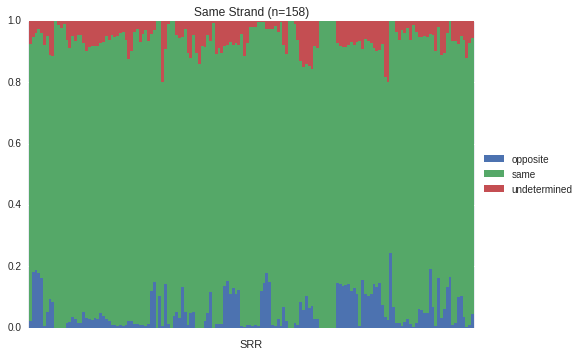

In [8]:
# Plot Strandedness same strand samples
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_flags': 'same_strand'}
            ]
        },
    },
    {
        '$project': {
            'srx': '$srx',
            'srr': '$runs.srr',
            'same': '$runs.pre_aln_workflow.infer_expeirment.same_strand',
            'opposite': '$runs.pre_aln_workflow.infer_expeirment.opposite_strand',
            'undetermined': '$runs.pre_aln_workflow.infer_expeirment.undertermined',
        }
    }
])

df = pd.DataFrame(list(agg))
df.set_index(['srx', 'srr'], inplace=True)

ax = df.plot.bar(stacked=True, width=1, linewidth=0)
ax.set_xticklabels([]);
ax.set_xlabel('SRR');
ax.set_ylim([0,1]);
ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5));
num = df.shape[0]
ax.set_title('Same Strand (n={:,})'.format(num));

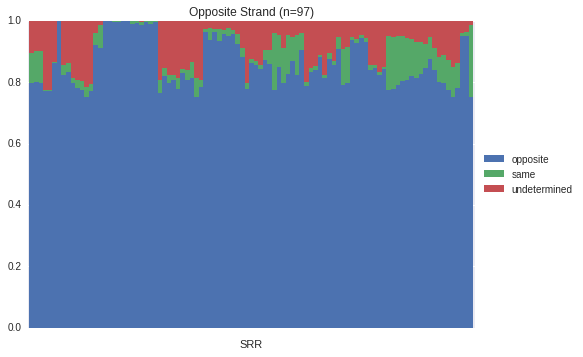

In [9]:
# Plot Strandedness opposite strand samples
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_flags': 'opposite_strand'}
            ]
        },
    },
    {
        '$project': {
            'srx': '$srx',
            'srr': '$runs.srr',
            'same': '$runs.pre_aln_workflow.infer_expeirment.same_strand',
            'opposite': '$runs.pre_aln_workflow.infer_expeirment.opposite_strand',
            'undetermined': '$runs.pre_aln_workflow.infer_expeirment.undertermined',
        }
    }
])

df = pd.DataFrame(list(agg))
df.set_index(['srx', 'srr'], inplace=True)

ax = df.plot.bar(stacked=True, width=1, linewidth=0)
ax.set_xticklabels([]);
ax.set_xlabel('SRR');
ax.set_ylim([0,1]);
ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5));
num = df.shape[0]
ax.set_title('Opposite Strand (n={:,})'.format(num));

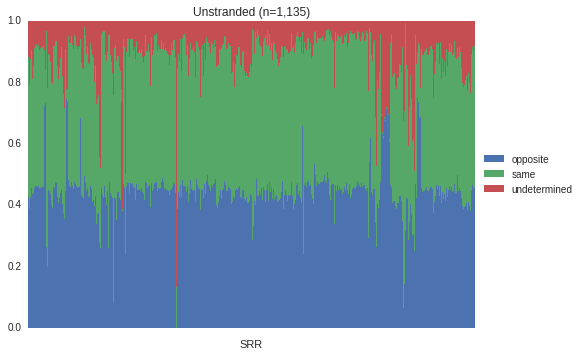

In [10]:
# Plot Strandedness unstranded samples
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_flags': 'unstranded'}

            ]
        },
    },
    {
        '$project': {
            'srx': '$srx',
            'srr': '$runs.srr',
            'same': '$runs.pre_aln_workflow.infer_expeirment.same_strand',
            'opposite': '$runs.pre_aln_workflow.infer_expeirment.opposite_strand',
            'undetermined': '$runs.pre_aln_workflow.infer_expeirment.undertermined',
        }
    }
])

df = pd.DataFrame(list(agg))
df.set_index(['srx', 'srr'], inplace=True)

ax = df.plot.bar(stacked=True, width=1, linewidth=0)
ax.set_xticklabels([]);
ax.set_xlabel('SRR');
ax.set_ylim([0,1]);
ax.legend(loc='center', bbox_to_anchor=(1.12, 0.5));
num = df.shape[0]
ax.set_title('Unstranded (n={:,})'.format(num));

### Determining Library Strategy

Brian went through part of the list by hand and saw that most of these putative samples were not RNA-seq. This is a perfect use of machine learning to classify samples. I can use Brian's annotations for training and various metrics that we can use as features.

#### Gene body coverage

Gene body coverage is a measure of how evenly the gene body is covered by the data. In RNA-seq we typically see a slight dip in coverage near the 5' and 3' ends and uniform coverage across the center.

In [11]:
# Grab picard RNA-seq metrics from database
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'}, 
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_workflow.picard_collectrnaseqmetrics': {'$exists': 1}}
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'flags': '$runs.pre_aln_flags',
            'metrics': '$runs.pre_aln_workflow.picard_collectrnaseqmetrics'
        }
    },
])

records = []
for record in agg:
    r = {}
    r['srx'] = record['srx']
    r['srr'] = record['srr']
    if 'SE' in record['flags']:
        r['strand'] = 'first'
    elif 'PE' in record['flags']:
        r['strand'] = 'second'
    else:
        r['strand'] = 'unstranded'
    
    for k, v in record['metrics'][r['strand']].items():
        r[k] = v
    records.append(r)

metrics = pd.DataFrame(records)
metrics.set_index(['srx', 'srr'], inplace=True)
metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS.replace('?', 0, inplace=True)
metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS.fillna(0, inplace=True)

# Import picard RNA-seq metrics histograms
dfs = []
_mapper = {
    'first': 'FIRST_READ_TRANSCRIPTION_STRAND',
    'second': 'SECOND_READ_TRANSCRIPTION_STRAND',
    'unstranded': 'NONE'
}
for srx, srr, strand in metrics.reset_index()[['srx', 'srr', 'strand']].values:
    try:
        fname = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.{strand}.picard.collectrnaseqmetrics'.format(srx=srx, srr=srr, strand=_mapper[strand])
        pic =  parse_picardCollect_hist(srr, fname)
        if pic is None:
            raise FileNotFoundError
        dfs.append(pic)
    except FileNotFoundError:
        print('Missing Files for: {}'.format(' -> '.join([srx, srr])))

hists = pd.concat(dfs)

Missing Files for: SRX1951557 -> SRR3925163
Missing Files for: SRX999968 -> SRR1980989
Missing Files for: SRX999967 -> SRR1980988
Missing Files for: SRX657937 -> SRR1521302
Missing Files for: SRX367011 -> SRR1015574
Missing Files for: SRX029067 -> SRR069830
Missing Files for: SRX029066 -> SRR069829
Missing Files for: SRX017849 -> SRR038284
Missing Files for: SRX014801 -> SRR032096
Missing Files for: SRX014799 -> SRR032094
Missing Files for: SRX014798 -> SRR032093
Missing Files for: SRX012159 -> SRR029030
Missing Files for: SRX012158 -> SRR029029
Missing Files for: SRX012157 -> SRR029028
Missing Files for: SRX1598174 -> SRR3184775
Missing Files for: SRX1598173 -> SRR3184774
Missing Files for: SRX1364749 -> SRR2757173
Missing Files for: SRX1364748 -> SRR2757108


**NOTE: These 18 SRRs are missing the histogram from picard RNA-seq Metrics. I am not sure why because all the logs look good. Need to go back and run on a few of these and see if I can figure out why!!**

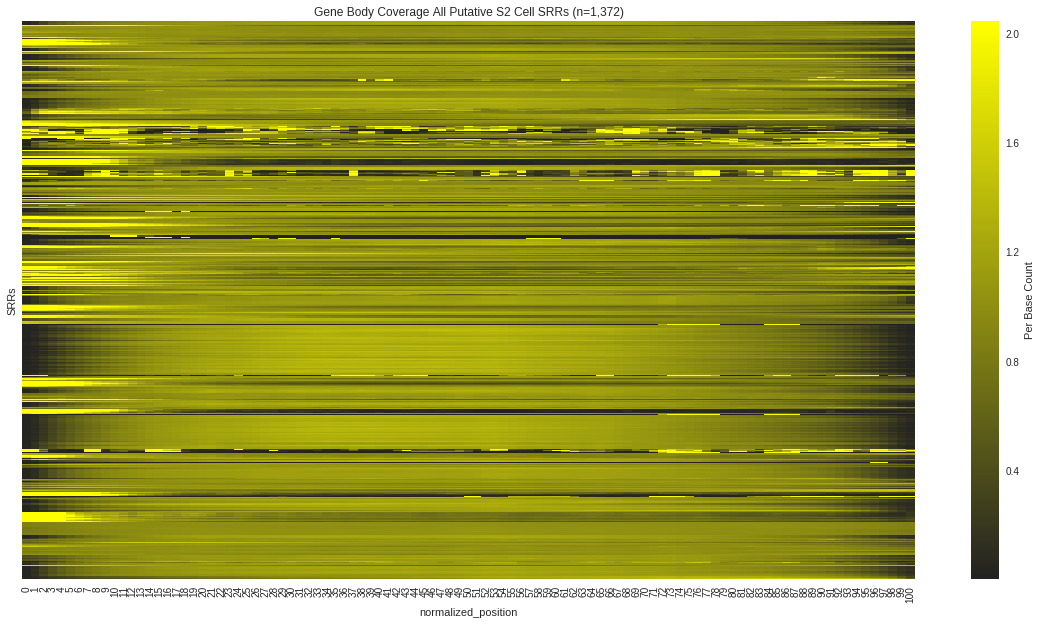

In [12]:
# Plot all data
_hists = hists.copy()
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(_hists, yticklabels=False, robust=True, cmap=sns.dark_palette('yellow', as_cmap=True), ax=ax, cbar_kws={'label': 'Per Base Count'});
ax.set_ylabel('SRRs')
ax.set_title('Gene Body Coverage All Putative S2 Cell SRRs (n={:,})'.format(_hists.shape[0]));

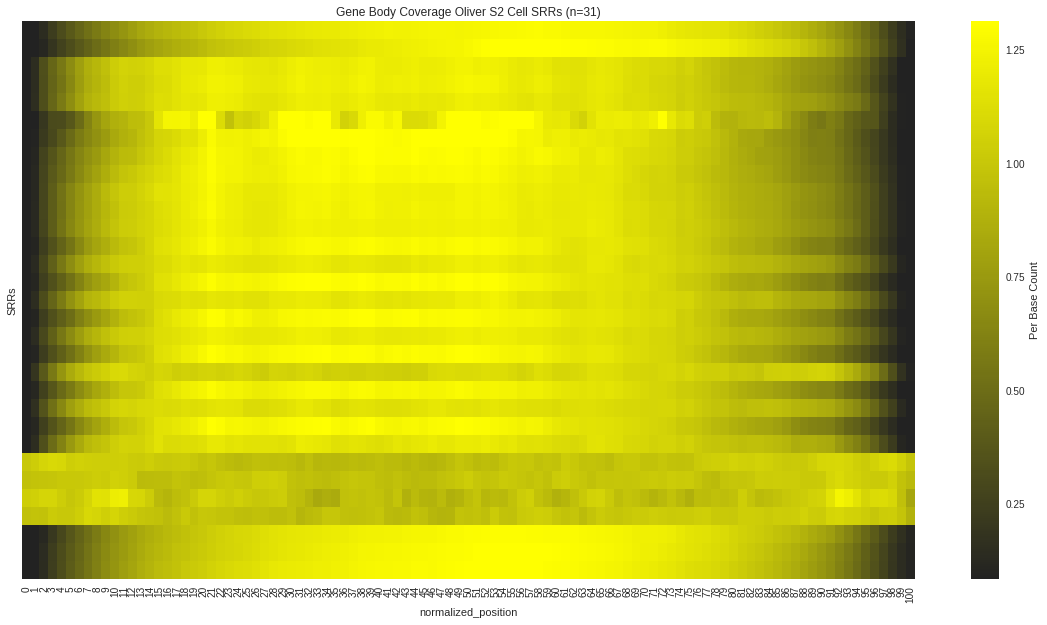

In [13]:
# Plot oliver data
_hists = hists[hists.index.isin(s2OliverIndex)]
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(_hists, yticklabels=False, robust=True, cmap=sns.dark_palette('yellow', as_cmap=True), ax=ax, cbar_kws={'label': 'Per Base Count'});
ax.set_ylabel('SRRs')
ax.set_title('Gene Body Coverage Oliver S2 Cell SRRs (n={:,})'.format(_hists.shape[0]));

#### Picard RNA-seq metrics

Picard has a program call RNA-seq metrics which calculates a variety of summary statistics including:

* Percent Intergenic
* Median CV
* Median 5' to 3' Bias

The CV and 5' 3' bias will give us a different look at the gene body coverage, while the percent intergenic will give an idea of if reads are even mapped to intergenic regions suggesting a the sample is not RNA-seq.


In [14]:
# Grab picard mark duplicate metrics from database
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'}, 
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_workflow.picard_markduplicates': {'$exists': 1}}
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'metrics': '$runs.pre_aln_workflow.picard_markduplicates'
        }
    },
])

records = []
for record in agg:
    r = {}
    r['srx'] = record['srx']
    r['srr'] = record['srr']
    for k, v in record['metrics'].items():
        r[k] = v
    records.append(r)

dups = pd.DataFrame(records)
dups.set_index(['srx', 'srr'], inplace=True)

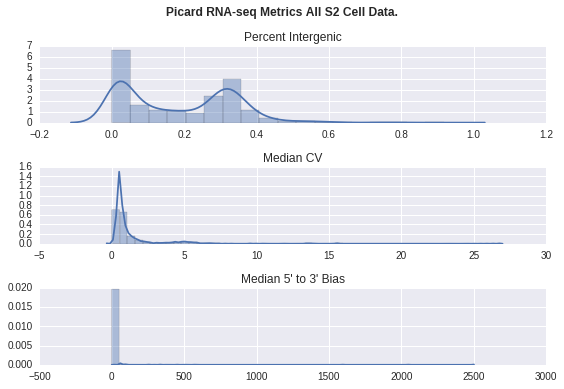

In [15]:
# plot various metrics
_metrics = metrics.copy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax1)
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax2)
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax3)

ax1.set_title('Percent Intergenic')
ax1.set_xlabel('')
ax2.set_title('Median CV')
ax2.set_xlabel('')
ax3.set_title('Median 5\' to 3\' Bias')
ax3.set_xlabel('')

plt.suptitle('Picard RNA-seq Metrics All S2 Cell Data.', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

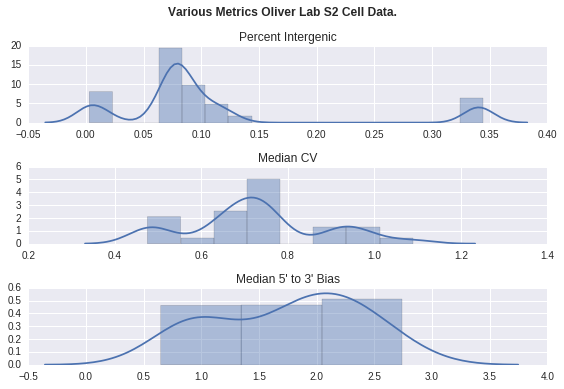

In [16]:
# plot various metrics Oliver data
_metrics = metrics[metrics.index.droplevel(0).isin(s2OliverIndex)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax1)
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax2)
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax3)

ax1.set_title('Percent Intergenic')
ax1.set_xlabel('')
ax2.set_title('Median CV')
ax2.set_xlabel('')
ax3.set_title('Median 5\' to 3\' Bias')
ax3.set_xlabel('')

plt.suptitle('Various Metrics Oliver Lab S2 Cell Data.', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

#### Junction Counts

In [17]:
# Grab featurecounts junction counts
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'}, 
                {'runs.srr': {'$in': s2}},
                {'runs.pre_aln_workflow.featurecounts': {'$exists': 1}}
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'junction_counts': '$runs.pre_aln_workflow.featurecounts.Assigned_Junction'
        }
    },
])

_jcount = pd.DataFrame(list(agg))
_jcount.set_index(['srx', 'srr'], inplace=True)

# Get other Junction features
_records = []
for srx, srr in _jcount.index.tolist():
    try:
        _features = parse_featureCounts_counts(srr, 
            '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts'.format(srx=srx, srr=srr))
        _junctions = parse_featureCounts_jcounts(srr, 
             '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts.jcounts'.format(srx=srx, srr=srr))
        _junctions['diff'] = np.abs(_junctions.Site1_location - _junctions.Site2_location)

        _filter = (
            (~_junctions.PrimaryGene.isnull()) &
            (_junctions.Site1_chr == _junctions.Site2_chr) &
            (_junctions['diff'] > 10) &
            (_junctions['diff'] < 300000) &
            (_junctions['count'] > 5)
        )

        try:
            _ratio = _junctions.loc[_filter, 'count'].sum() / _features[_features > 10].sum()
        except ZeroDivisionError:
            _ratio = 0

        _records.append({
            'srx': srx,
            'srr': srr,
            'num_junctions_covered': _junctions[_filter].shape[0],
            'num_features_covered': _features[_features > 10].shape[0],
            'prop_junc_reads_to_feature_reads': _ratio
        })
    except FileNotFoundError:
        print('Missing file: {srx} -> {srr}'.format(srx=srx, srr=srr))

_df = pd.DataFrame(_records).set_index(['srx', 'srr'])
jcount = _jcount.join(_df)

Missing file: SRX501034 -> SRR1204770
Missing file: SRX501033 -> SRR1204769
Missing file: SRX501031 -> SRR1204767
Missing file: SRX187086 -> SRR569914
Missing file: SRX187085 -> SRR569913


/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in long_scalars


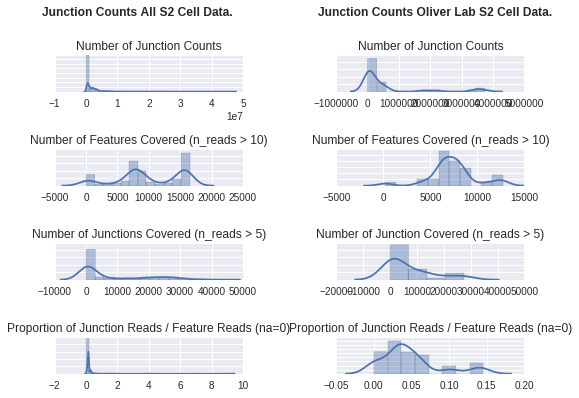

In [19]:
# plot number of reads spanning junctions all s2 data
fig, axes = plt.subplots(4, 2)
axes = axes.flatten()

_jcount = jcount
sns.distplot(_jcount.junction_counts, ax=axes[0])
axes[0].set_title('Number of Junction Counts')
axes[0].set_xlabel('')
axes[0].set_yticklabels([])

_jcount = jcount[jcount.index.droplevel(0).isin(s2OliverIndex)]
sns.distplot(_jcount.junction_counts, ax=axes[1])
axes[1].set_title('Number of Junction Counts')
axes[1].set_xlabel('')
axes[1].set_yticklabels([])

_jcount = jcount
sns.distplot(_jcount.num_features_covered.dropna(), ax=axes[2])
axes[2].set_title('Number of Features Covered (n_reads > 10)')
axes[2].set_xlabel('')
axes[2].set_yticklabels([])

_jcount = jcount[jcount.index.droplevel(0).isin(s2OliverIndex)]
sns.distplot(_jcount.num_features_covered.dropna(), ax=axes[3])
axes[3].set_title('Number of Features Covered (n_reads > 10)')
axes[3].set_xlabel('')
axes[3].set_yticklabels([])

_jcount = jcount
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=axes[4])
axes[4].set_title('Number of Junctions Covered (n_reads > 5)')
axes[4].set_xlabel('')
axes[4].set_yticklabels([])

_jcount = jcount[jcount.index.droplevel(0).isin(s2OliverIndex)]
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=axes[5])
axes[5].set_title('Number of Junction Covered (n_reads > 5)')
axes[5].set_xlabel('')
axes[5].set_yticklabels([])

_jcount = jcount
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=axes[6])
axes[6].set_title('Proportion of Junction Reads / Feature Reads (na=0)')
axes[6].set_xlabel('')
axes[6].set_yticklabels([])

_jcount = jcount[jcount.index.droplevel(0).isin(s2OliverIndex)]
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=axes[7])
axes[7].set_title('Proportion of Junction Reads / Feature Reads (na=0)')
axes[7].set_xlabel('')
axes[7].set_yticklabels([])

plt.text(0.07, .98, 'Junction Counts All S2 Cell Data.', transform=fig.transFigure, fontweight='bold')
plt.text(.55, .98, 'Junction Counts Oliver Lab S2 Cell Data.', transform=fig.transFigure, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

#### Look at metrics using Brian's classifications

Next I want to look at how the metrics look in the different class hand annotated by Brian. Making sure that the metrics look difference across classes.

In [20]:
# Import Brian's annotations
bo = pd.read_excel('../../data/brian/20170428_s2cell_1243bo.xlsx', header=(0, 1))
boFlags = bo.loc[:, ('oliver', 'notes_and_flags')].dropna()

# Normalize Brian's flags 
mRNA_sample = boFlags[boFlags.str.lower().str.contains('mrna') | boFlags.str.lower().str.contains('rnaseq')].index.tolist()
chip_sample = boFlags[boFlags.str.lower().str.contains('chip')].index.tolist()
star_sample = boFlags[boFlags.str.lower().str.contains('star')].index.tolist()
miRNA_sample = boFlags[boFlags.str.lower().str.contains('mirna')].index.tolist()

# Get the SRRs using BioSamples
def get_srr(samples):
    agg = remap.aggregate([
        {'$unwind': '$runs'},
        {
            '$match': {
                #'runs.pre_aln_flags': 'complete',
                #'runs.srr': {'$in': s2},
                'sample.biosample': {'$in': samples}      
            }
        },
        {
            '$project': {
                '_id': 0,
                'srr': '$runs.srr'
            }
        },
    ])

    return list(set([x['srr'] for x in agg]))

mRNA = get_srr(mRNA_sample)
chip = get_srr(chip_sample)
star = get_srr(star_sample)
miRNA = get_srr(miRNA_sample)

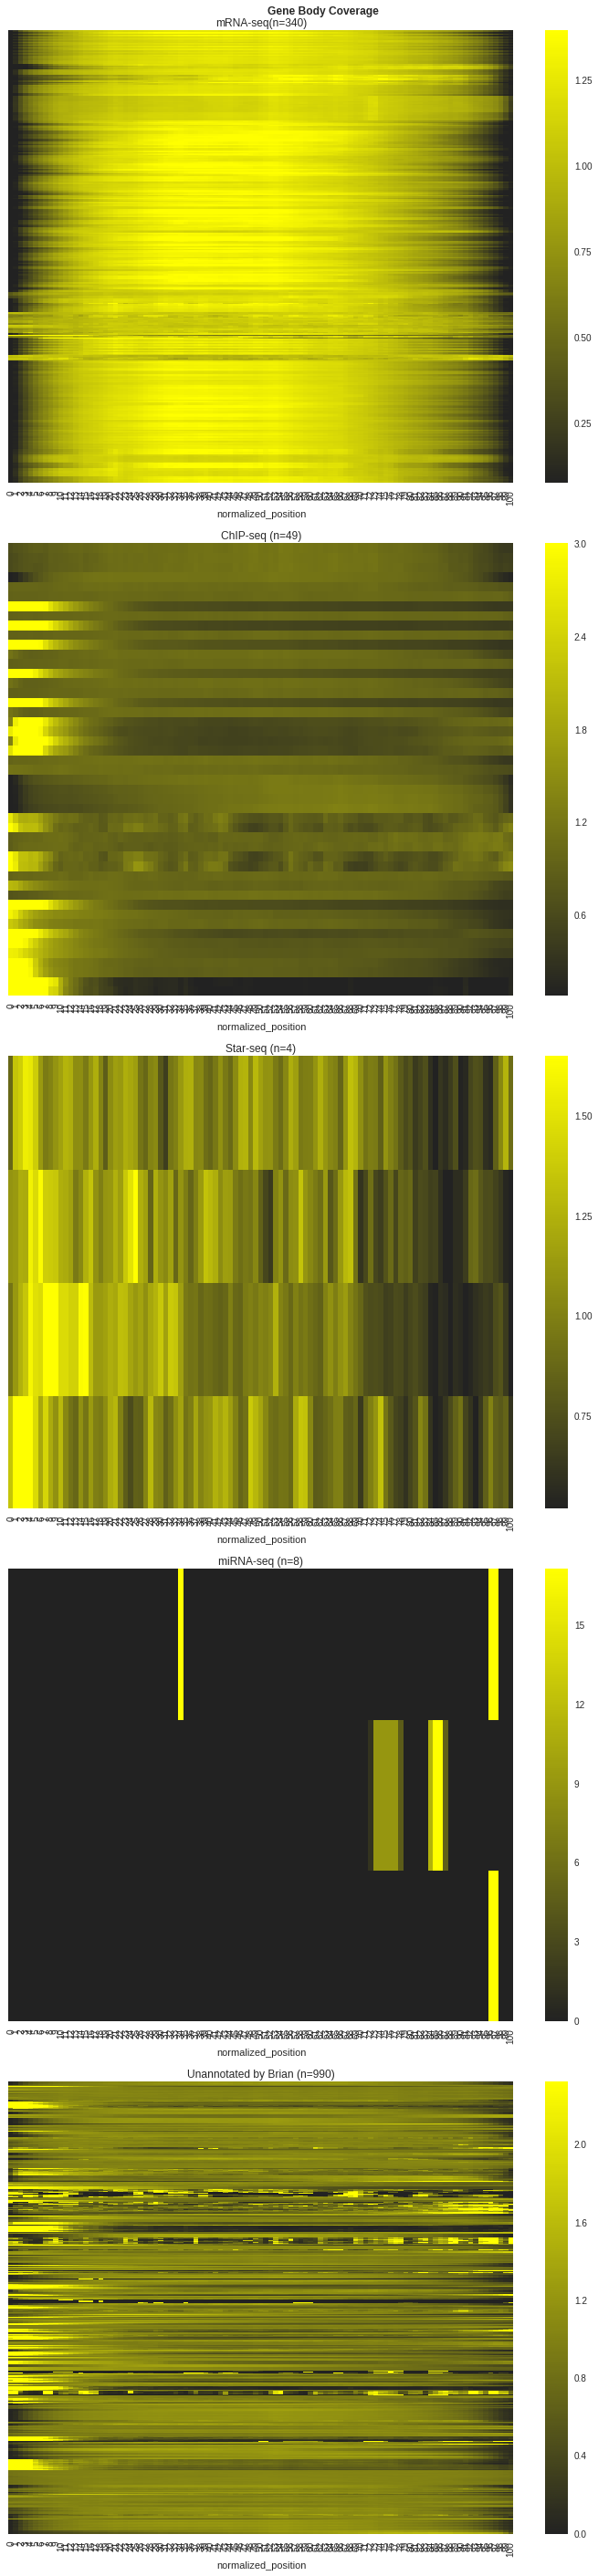

In [21]:
# Plot hists for Brian's different classes
fig, axes = plt.subplots(5, 1, figsize=(10, 40))
axes = axes.flatten()

sns.heatmap(hists[hists.index.isin(mRNA)], robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[0])
axes[0].set_title('mRNA-seq(n={:,})'.format(len(mRNA)));

sns.heatmap(hists[hists.index.isin(chip)], robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[1])
axes[1].set_title('ChIP-seq (n={:,})'.format(len(chip)));

sns.heatmap(hists[hists.index.isin(star)], robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[2])
axes[2].set_title('Star-seq (n={:,})'.format(len(star)));

sns.heatmap(hists[hists.index.isin(miRNA)], robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[3])
axes[3].set_title('miRNA-seq (n={:,})'.format(len(miRNA)));

_unannotated_hists = hists[~hists.index.isin(mRNA+chip+star+miRNA)]
sns.heatmap(_unannotated_hists, robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[4])
axes[4].set_title('Unannotated by Brian (n={:,})'.format(_unannotated_hists.shape[0]));

plt.suptitle('Gene Body Coverage', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .98]);

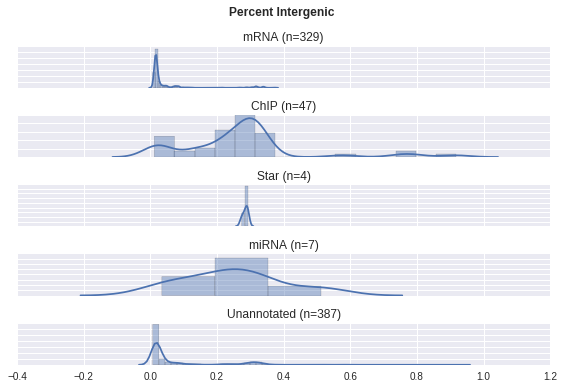

In [22]:
# plot percent intergenic for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(chip)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(star)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax3)
ax3.set_title('Star (n={:,})'.format(_metrics.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(miRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax4)
ax4.set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_metrics.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Percent Intergenic', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

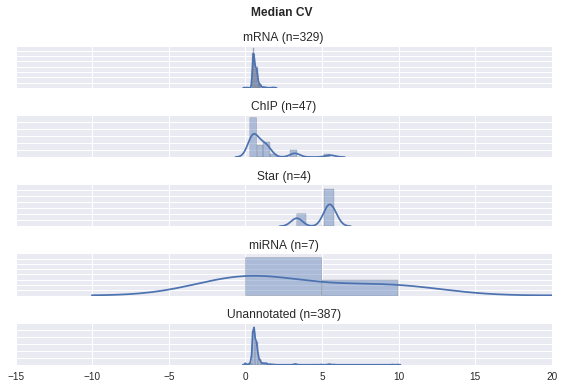

In [23]:
# plot median CV for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(chip)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(star)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax3)
ax3.set_title('Star (n={:,})'.format(_metrics.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(miRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax4)
ax4.set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_metrics.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Median CV', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

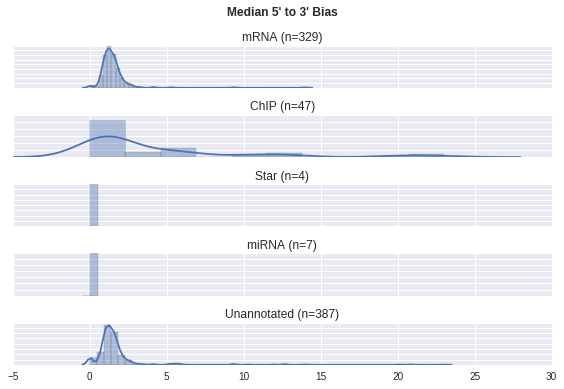

In [24]:
# plot median 5/3 prime bias for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(chip)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(star)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax3, kde=False)
ax3.set_title('Star (n={:,})'.format(_metrics.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(miRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax4, kde=False)
ax4.set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_metrics.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Median 5\' to 3\' Bias', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

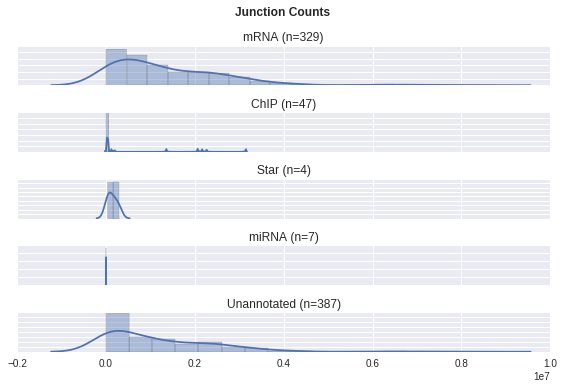

In [25]:
# plot Junction counts for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA)]
sns.distplot(_jcount.junction_counts, ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_jcount.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(chip)]
sns.distplot(_jcount.junction_counts, ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_jcount.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(star)]
sns.distplot(_jcount.junction_counts, ax=ax3)
ax3.set_title('Star (n={:,})'.format(_jcount.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(miRNA)]
sns.distplot(_jcount.junction_counts, ax=ax4)
ax4.set_title('miRNA (n={:,})'.format(_jcount.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_jcount.junction_counts, ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_jcount.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Junction Counts', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

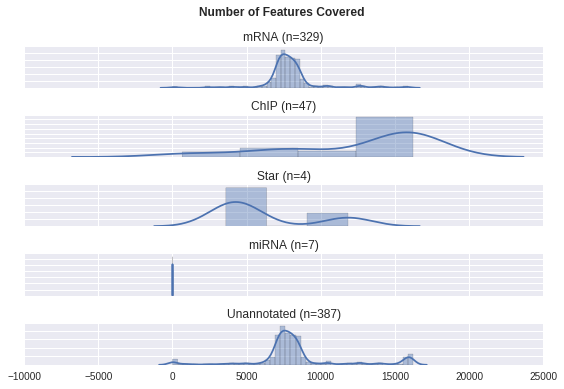

In [26]:
# plot num of covered features for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA)]
sns.distplot(_jcount.num_features_covered.dropna(), ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_jcount.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(chip)]
sns.distplot(_jcount.num_features_covered.dropna(), ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_jcount.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(star)]
sns.distplot(_jcount.num_features_covered.dropna(), ax=ax3)
ax3.set_title('Star (n={:,})'.format(_jcount.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(miRNA)]
sns.distplot(_jcount.num_features_covered.dropna(), ax=ax4)
ax4.set_title('miRNA (n={:,})'.format(_jcount.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_jcount.num_features_covered.dropna(), ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_jcount.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Number of Features Covered', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

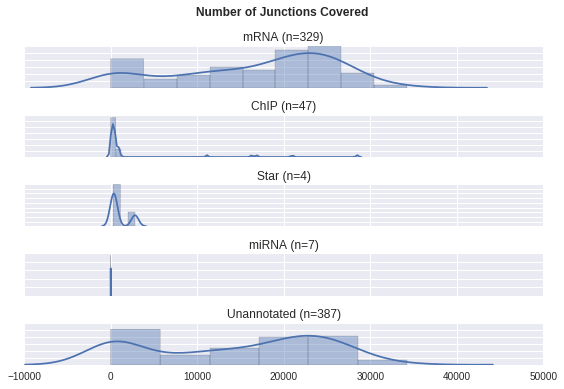

In [27]:
# plot num of covered features for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA)]
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_jcount.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(chip)]
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_jcount.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(star)]
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=ax3)
ax3.set_title('Star (n={:,})'.format(_jcount.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(miRNA)]
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=ax4)
ax4.set_title('miRNA (n={:,})'.format(_jcount.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_jcount.num_junctions_covered.dropna(), ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_jcount.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Number of Junctions Covered', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

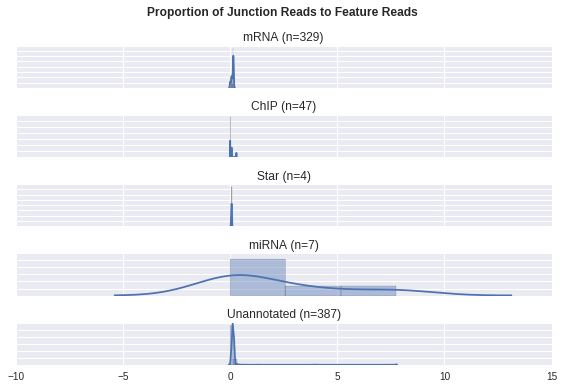

In [28]:
# plot prop junc reads to feature reads for Oliver annotation
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA)]
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=ax1)
ax1.set_title('mRNA (n={:,})'.format(_jcount.shape[0]))
ax1.set_xlabel('')
ax1.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(chip)]
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=ax2)
ax2.set_title('ChIP (n={:,})'.format(_jcount.shape[0]))
ax2.set_xlabel('')
ax2.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(star)]
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=ax3)
ax3.set_title('Star (n={:,})'.format(_jcount.shape[0]))
ax3.set_xlabel('')
ax3.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(miRNA)]
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=ax4)
ax4.set_title('miRNA (n={:,})'.format(_jcount.shape[0]))
ax4.set_xlabel('')
ax4.set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA+chip+star+miRNA)]
sns.distplot(_jcount.prop_junc_reads_to_feature_reads.replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(), ax=ax5)
ax5.set_title('Unannotated (n={:,})'.format(_jcount.shape[0]))
ax5.set_xlabel('')
ax5.set_yticklabels('')

plt.suptitle('Proportion of Junction Reads to Feature Reads', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

#### Gene Body Coverage Classification of Unknown Samples

Use a SVM to classify unannotated values. Here I use all annotated values as training data (i.e., I have no test data). 

**NOTE: I need to go back with these samples and hand annotate them for checking how well the classifier performed.**

##### Run Classifier

In [29]:
# Format data for classifier

# Labels
Y = pd.DataFrame(index=hists.index, columns=['class'])
Y[Y.index.isin(mRNA)] = 0
Y[Y.index.isin(chip)] = 1
Y[Y.index.isin(star)] = 2
Y[Y.index.isin(miRNA)] = 3
Y.dropna(inplace=True)

# features
_metrics = metrics.copy()
_metrics.index = _metrics.index.droplevel(0)
_jcount = jcount.copy()
_jcount.index = _jcount.index.droplevel(0)
features = hists.join(_metrics[['PCT_INTERGENIC_BASES', 'MEDIAN_CV_COVERAGE', 'MEDIAN_5PRIME_TO_3PRIME_BIAS']]).join(_jcount)

# Set up scaler
features = features.replace(-np.inf, np.nan).replace(np.inf, np.nan).fillna(0)
scaler = preprocessing.StandardScaler().fit(features.values)

# Get Feature matrix
X = scaler.transform(features.loc[Y.index, :].values.astype(float))

# Things that still need to be classified
UK = scaler.transform(features[~features.index.isin(Y.index.tolist())].values.astype(float))
UK_index = features[~features.index.isin(Y.index.tolist())].index.tolist()

# Make Y an array now
Y = Y.values.flatten().astype(int)

In [30]:
# Run SVM classification
clf = svm.LinearSVC()
clf.fit(X, Y)
dec = clf.decision_function(UK)

# Pull out classes
# Positive values are the mostlikely class
classes = []
for row in dec > 0:
    classes.append(row.argmax())

# remap class names
_mapper = {
    0: 'mRNA',
    1: 'chip',
    2: 'star',
    3: 'miRNA'
}

classified = []
for k, v in zip(UK_index, classes):
    classified.append({'srr': k, 'class': _mapper[v]})

dfClasses = pd.DataFrame(classified).set_index('srr')

dfClasses['class'].unique()

array(['mRNA', 'chip', 'star', 'miRNA'], dtype=object)

##### Plot metrics and compare to hand annotated

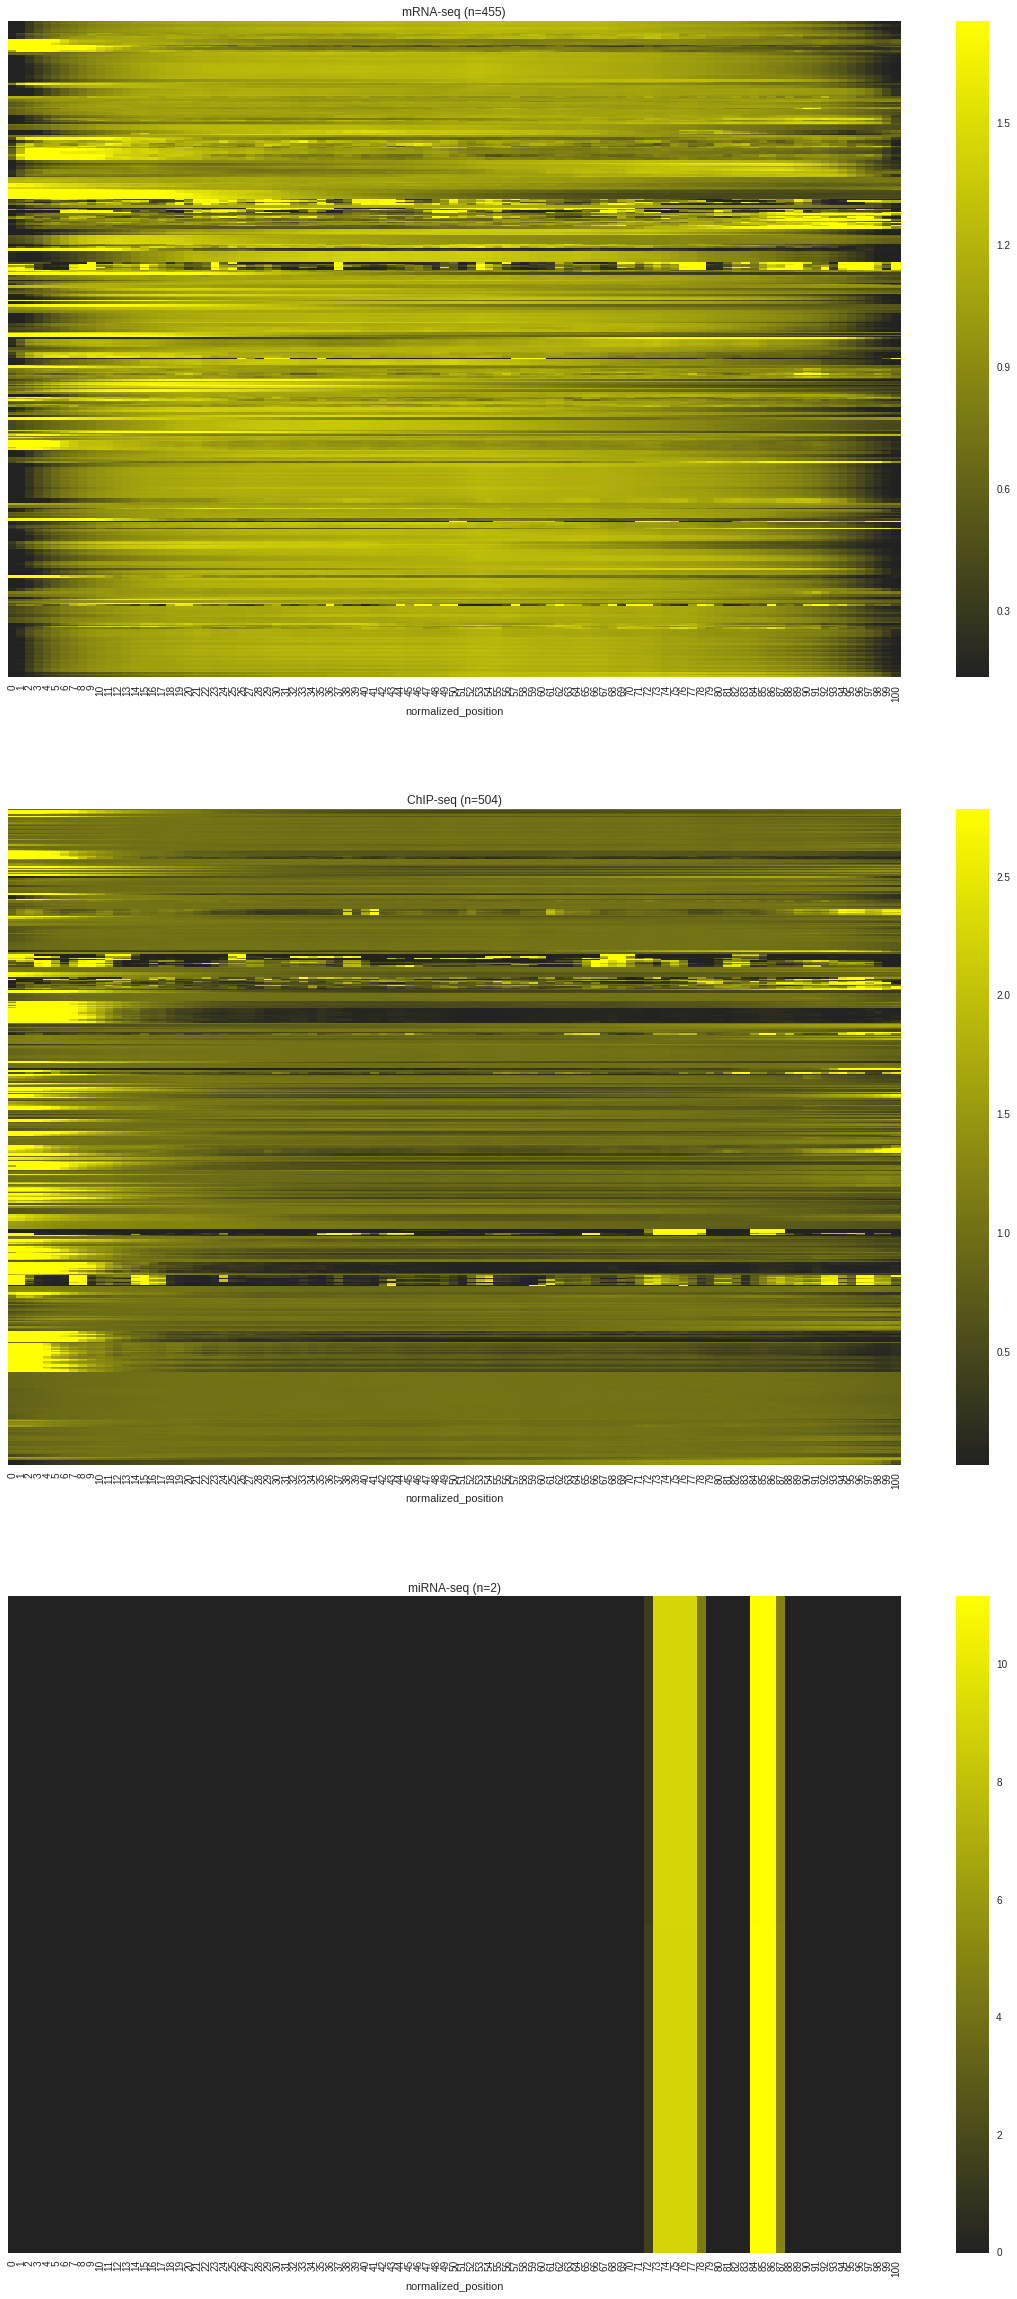

In [31]:
# Plot classified values Gene body coverage
fig, axes = plt.subplots(3, 1, figsize=(20, 40))
axes = axes.flatten()

_hists = hists[hists.index.isin(dfClasses[dfClasses['class'] == 'mRNA'].index.tolist())]
sns.heatmap(_hists, robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[0])
axes[0].set_title('mRNA-seq (n={:,})'.format(_hists.shape[0]));

_hists = hists[hists.index.isin(dfClasses[dfClasses['class'] == 'chip'].index.tolist())]
sns.heatmap(_hists, robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[1])
axes[1].set_title('ChIP-seq (n={:,})'.format(_hists.shape[0]));

_hists = hists[hists.index.isin(dfClasses[dfClasses['class'] == 'miRNA'].index.tolist())]
sns.heatmap(_hists, robust=True, yticklabels=False, cmap=sns.dark_palette('yellow', as_cmap=True), ax=axes[2])
axes[2].set_title('miRNA-seq (n={:,})'.format(_hists.shape[0]));

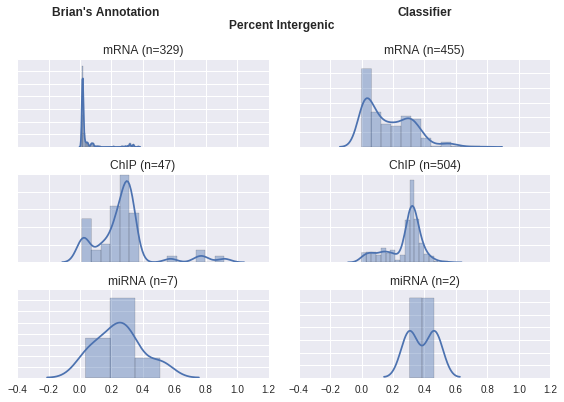

In [45]:
# plot percent intergenic for classified data
fig, axes = plt.subplots(3, 2, sharex=True)
axes = axes.flatten()

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=axes[0])
axes[0].set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
axes[0].set_xlabel('')
axes[0].set_yticklabels('')

_mRNA = dfClasses[dfClasses['class'] == 'mRNA'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_mRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=axes[1])
axes[1].set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
axes[1].set_xlabel('')
axes[1].set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(chip)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=axes[2])
axes[2].set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
axes[2].set_xlabel('')
axes[2].set_yticklabels('')

_chip = dfClasses[dfClasses['class'] == 'chip'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_chip)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=axes[3])
axes[3].set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
axes[3].set_xlabel('')
axes[3].set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(miRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=axes[4])
axes[4].set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
axes[4].set_xlabel('')
axes[4].set_yticklabels('')

_miRNA = dfClasses[dfClasses['class'] == 'miRNA'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_miRNA)]
sns.distplot(_metrics.PCT_INTERGENIC_BASES, ax=axes[5])
axes[5].set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
axes[5].set_xlabel('')
axes[5].set_yticklabels('')

plt.suptitle('Percent Intergenic', fontweight='bold')
plt.text(0.1, .99, "Brian's Annotation", transform=fig.transFigure, fontweight='bold')
plt.text(.70, .99, "Classifier", transform=fig.transFigure, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

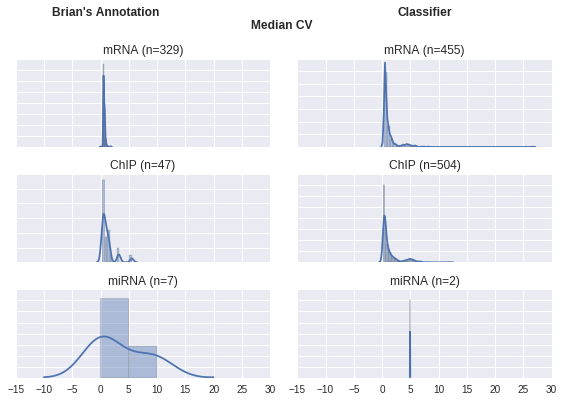

In [46]:
# plot percent median cv for classified data
fig, axes = plt.subplots(3, 2, sharex=True)
axes = axes.flatten()

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=axes[0])
axes[0].set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
axes[0].set_xlabel('')
axes[0].set_yticklabels('')

_mRNA = dfClasses[dfClasses['class'] == 'mRNA'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_mRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=axes[1])
axes[1].set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
axes[1].set_xlabel('')
axes[1].set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(chip)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=axes[2])
axes[2].set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
axes[2].set_xlabel('')
axes[2].set_yticklabels('')

_chip = dfClasses[dfClasses['class'] == 'chip'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_chip)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=axes[3])
axes[3].set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
axes[3].set_xlabel('')
axes[3].set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(miRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=axes[4])
axes[4].set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
axes[4].set_xlabel('')
axes[4].set_yticklabels('')

_miRNA = dfClasses[dfClasses['class'] == 'miRNA'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_miRNA)]
sns.distplot(_metrics.MEDIAN_CV_COVERAGE, ax=axes[5])
axes[5].set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
axes[5].set_xlabel('')
axes[5].set_yticklabels('')

plt.suptitle('Median CV', fontweight='bold')
plt.text(0.1, .99, "Brian's Annotation", transform=fig.transFigure, fontweight='bold')
plt.text(.70, .99, "Classifier", transform=fig.transFigure, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

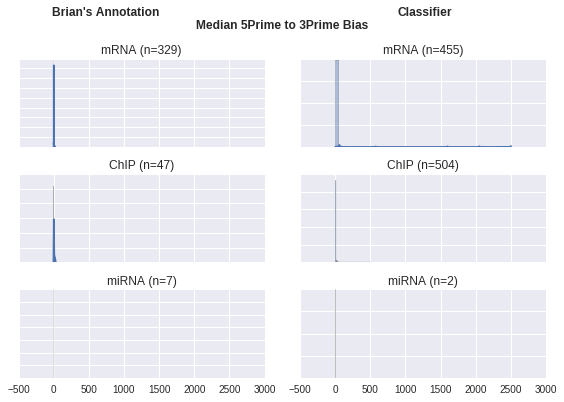

In [47]:
# plot percent median 5prime to 3prime bias for classified data
fig, axes = plt.subplots(3, 2, sharex=True)
axes = axes.flatten()

_metrics = metrics[metrics.index.droplevel(0).isin(mRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=axes[0])
axes[0].set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
axes[0].set_xlabel('')
axes[0].set_yticklabels('')

_mRNA = dfClasses[dfClasses['class'] == 'mRNA'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_mRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=axes[1])
axes[1].set_title('mRNA (n={:,})'.format(_metrics.shape[0]))
axes[1].set_xlabel('')
axes[1].set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(chip)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=axes[2])
axes[2].set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
axes[2].set_xlabel('')
axes[2].set_yticklabels('')

_chip = dfClasses[dfClasses['class'] == 'chip'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_chip)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=axes[3], kde=False)
axes[3].set_title('ChIP (n={:,})'.format(_metrics.shape[0]))
axes[3].set_xlabel('')
axes[3].set_yticklabels('')

_metrics = metrics[metrics.index.droplevel(0).isin(miRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=axes[4], kde=False)
axes[4].set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
axes[4].set_xlabel('')
axes[4].set_yticklabels('')

_miRNA = dfClasses[dfClasses['class'] == 'miRNA'].index.tolist()
_metrics = metrics[metrics.index.droplevel(0).isin(_miRNA)]
sns.distplot(_metrics.MEDIAN_5PRIME_TO_3PRIME_BIAS, ax=axes[5], kde=False)
axes[5].set_title('miRNA (n={:,})'.format(_metrics.shape[0]))
axes[5].set_xlabel('')
axes[5].set_yticklabels('')

plt.suptitle('Median 5Prime to 3Prime Bias', fontweight='bold')
plt.text(0.1, .99, "Brian's Annotation", transform=fig.transFigure, fontweight='bold')
plt.text(.70, .99, "Classifier", transform=fig.transFigure, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

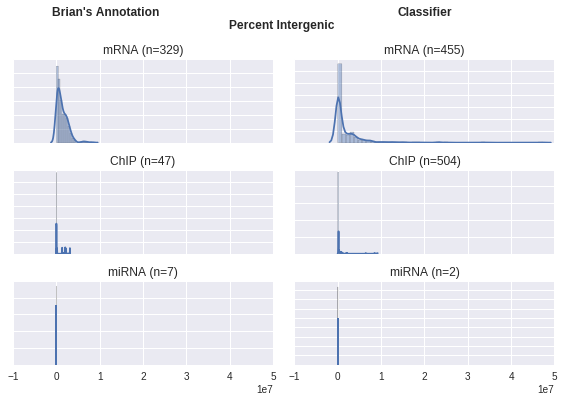

In [49]:
# plot percent intergenic for classified data
fig, axes = plt.subplots(3, 2, sharex=True)
axes = axes.flatten()

_jcount = jcount[jcount.index.droplevel(0).isin(mRNA)]
sns.distplot(_jcount.junction_counts, ax=axes[0])
axes[0].set_title('mRNA (n={:,})'.format(_jcount.shape[0]))
axes[0].set_xlabel('')
axes[0].set_yticklabels('')

_mRNA = dfClasses[dfClasses['class'] == 'mRNA'].index.tolist()
_jcount = jcount[jcount.index.droplevel(0).isin(_mRNA)]
sns.distplot(_jcount.junction_counts, ax=axes[1])
axes[1].set_title('mRNA (n={:,})'.format(_jcount.shape[0]))
axes[1].set_xlabel('')
axes[1].set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(chip)]
sns.distplot(_jcount.junction_counts, ax=axes[2])
axes[2].set_title('ChIP (n={:,})'.format(_jcount.shape[0]))
axes[2].set_xlabel('')
axes[2].set_yticklabels('')

_chip = dfClasses[dfClasses['class'] == 'chip'].index.tolist()
_jcount = jcount[jcount.index.droplevel(0).isin(_chip)]
sns.distplot(_jcount.junction_counts, ax=axes[3])
axes[3].set_title('ChIP (n={:,})'.format(_jcount.shape[0]))
axes[3].set_xlabel('')
axes[3].set_yticklabels('')

_jcount = jcount[jcount.index.droplevel(0).isin(miRNA)]
sns.distplot(_jcount.junction_counts, ax=axes[4])
axes[4].set_title('miRNA (n={:,})'.format(_jcount.shape[0]))
axes[4].set_xlabel('')
axes[4].set_yticklabels('')

_miRNA = dfClasses[dfClasses['class'] == 'miRNA'].index.tolist()
_jcount = jcount[jcount.index.droplevel(0).isin(_miRNA)]
sns.distplot(_jcount.junction_counts, ax=axes[5])
axes[5].set_title('miRNA (n={:,})'.format(_jcount.shape[0]))
axes[5].set_xlabel('')
axes[5].set_yticklabels('')

plt.suptitle('Percent Intergenic', fontweight='bold')
plt.text(0.1, .99, "Brian's Annotation", transform=fig.transFigure, fontweight='bold')
plt.text(.70, .99, "Classifier", transform=fig.transFigure, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, .95])

##### Compare classification to NCBI metadata

Typically with these kind of classification I should have split the training set into 75% training and 25% testing. However, with such a small training dataset I did not want to split it at this point. Another option is to compare with metadata from the NCBI.SRA database. I don't completely trust this metadata -- which is why I am just not using their annotations to begin with -- but they should be mostly right.

The SRA database has additional classes ([here](http://sramongo.readthedocs.io/en/latest/sraConstants.html#library-strategy)) that I have not tried to separate, however it may be useful to see if these samples have some of these other classifiers. 

Ultimately it would be best to hand annotated additional samples and use them as a validation of the classifier.

In [50]:
# Combine NCBI Metadata classification with SVM classification

# Get list of SVM classified SRRs.
testClassSRR = dfClasses.index.tolist()

# Get NCBI annotation of library strategy
ncbiAnno = pd.DataFrame(list(ncbi.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': testClassSRR}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr',
            'strategy': '$sra.experiment.library_strategy',
        }
    },
])))

ncbiAnno.set_index('srr', inplace=True)
ncbiAnno.strategy.unique()

# Map SVM class labels to match NCBI labels.
dfClassesMapped = dfClasses.applymap(lambda x: {
    'mRNA': 'RNA-Seq', 
    'chip': 'ChIP-Seq', 
    'star': 'OTHER', 
    'miRNA': 'miRNA-Seq'}[x])

# Merge SVM class labels with NCBI labels
mergedClasses = dfClassesMapped.join(ncbiAnno, how='left')

# Look at differences between NCBI and classifier
pd.crosstab(mergedClasses['class'], mergedClasses['strategy'], margins=True)

strategy,ChIP-Seq,DNase-Hypersensitivity,MNase-Seq,OTHER,POOLCLONE,RIP-Seq,RNA-Seq,WGS,miRNA-Seq,All
class,,,,,,,,,,
ChIP-Seq,254,4,50,95,0,12,49,36,4,504
OTHER,0,0,0,17,0,1,2,0,9,29
RNA-Seq,111,3,18,75,4,38,201,0,5,455
miRNA-Seq,0,0,0,0,0,0,2,0,0,2
All,365,7,68,187,4,51,254,36,18,990


Unfortunately, there are large differences, however there are a few candidate samples that I can look at to get an idea on if the differences are NCBI mistakes or the classifier.

###### miRNA exploration

In [37]:
# Get list of miRNA SRRs and pull out BioSample to looking in biometa-app
_miRNA = dfClasses[dfClasses['class'] == 'miRNA'].index.tolist()

bs = [x['_id'] for x in biometa.find({'experiments.runs': {'$in': _miRNA}}, {'_id': 1})]

There are 2 SRRs that the classifier calls miRNA-Seq, but NCBI says are RNA-seq. This translate into the following BioSamples:

{{ ', '.join(bs) }}

Which corresponds to two BioProjects (PRJNA137667, PRJNA119663) submitted by the same authors (Perrimon group). Both Projects are shRNA knockdowns of *dpp* or *r2d2*. In the papers they state that these are actually small RNA libraries (19-24 nt).

###### ChIP Seq exploration

A quick look at samples that I classify as RNA-Seq that are ChIP-Seq in SRA is suggests that the classifier could use some work. The handful I looked at do seem like they are chip-seq.

The biggest problem with SRA metadata is human error. While something like the miRNA example above seems likely because perhaps the miRNA-seq category did not exists at the time. These kind of errors are probably less likely with ChIP-Seq. 

In [38]:
_chip = mergedClasses[(mergedClasses['class'] == 'RNA-Seq') & (mergedClasses['strategy'] == 'ChIP-Seq')].index.tolist()
bs = [x['_id'] for x in biometa.find({'experiments.runs': {'$in': _chip}}, {'_id': 1})]

print('There are {:,} SRRs that the classifier annotated '
      'as RNA-Seq that NCBI annotated as ChIP-Seq. '
      'This corresponds to {:,} BioSamples. '
      .format(len(_chip), len(bs))
     )

There are 111 SRRs that the classifier annotated as RNA-Seq that NCBI annotated as ChIP-Seq. This corresponds to 98 BioSamples. 
